# MoleculeDiffusionTransformer: Inverse diffusion model (Generate SMILES based on conditioning)

Reference:

#### Generative Discovery of Novel Chemical Designs using Diffusion Modeling and Transformer Architectures with Application to Deep Eutectic Solvents 

Rachel K. Luu1,2, Marcin Wysokowski1 , Markus J. Buehler1,3*

1 Laboratory for Atomistic and Molecular Mechanics (LAMM), Massachusetts Institute of Technology, 77 Massachusetts Ave., Cambridge, MA 02139, USA
2 Department of Materials Science and Engineering, Massachusetts Institute of Technology, 77 Massachusetts Ave., Cambridge, MA 02139, USA
3 Center for Computational Science and Engineering, Schwarzman College of Computing, Massachusetts Institute of Technology, 77 Massachusetts Ave., Cambridge, MA 02139, USA

mbuehler@MIT.EDU 

In [1]:
#!wget https://www.dropbox.com/s/gajj3euub7k9p9j/qm9_.csv?dl=0 -O qm9_.csv
#QM9: https://github.com/wengong-jin/chemprop

In [2]:
import os,sys
import math
import matplotlib.pyplot as plt 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
def exists(val):
    return val is not None

import torch

from sklearn.model_selection import train_test_split
#from tqdm import tqdm, trange
from tqdm.notebook import trange, tqdm

 
import torchvision
 
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
 
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from functools import partial, wraps

In [3]:
from MoleculeDiffusion import pad_sequence_lastchannel, train_loop_forward, sample_loop_forward
from MoleculeDiffusion import predict_properties_from_SMILES, QMDiffusionForward,reverse_tokenize
from MoleculeDiffusion import draw_and_save, draw_and_save_set, MoleculeDataset, get_data_loaders, is_novel 

2023-04-06 12:04:45.840775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 12:04:45.991753: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [5]:
import pandas as pd

from torch.utils.data import DataLoader,Dataset
import pandas as pd
import seaborn as sns
import time

In [6]:
print("Torch version:", torch.__version__) 

Torch version: 1.13.1+cu116


In [7]:
df=pd.read_csv("qm9_.csv")
df.describe()

,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298
count,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000
mean,2.706037,75.191296,-0.239977,0.011124,0.251100,1189.527450,0.148524,31.600676,-411.543985,-411.535513,-411.534569,-411.577397
std,1.530394,8.187793,0.022131,0.046936,0.047519,279.757172,0.033274,4.062471,40.060230,40.060012,40.060012,40.060741
min,0.000000,6.310000,-0.428600,-0.175000,0.024600,19.000200,0.015951,6.002000,-714.568061,-714.560153,-714.559209,-714.602138
25%,1.588700,70.380000,-0.252500,-0.023800,0.216300,1018.322600,0.125289,28.942000,-437.913936,-437.905942,-437.904997,-437.947682
50%,2.500000,75.500000,-0.241000,0.012000,0.249400,1147.585800,0.148329,31.555000,-417.864758,-417.857351,-417.856407,-417.895731
75%,3.636100,80.520000,-0.228700,0.049200,0.288200,1308.816600,0.171150,34.276000,-387.049166,-387.039746,-387.038802,-387.083279
max,29.556400,196.620000,-0.101700,0.193500,0.622100,3374.753200,0.273944,46.969000,-40.478930,-40.476062,-40.475117,-40.498597


In [8]:
df['smiles']

0                           C
1                           N
2                           O
3                         C#C
4                         C#N
                 ...         
133880    C1C2C3C4C5OC14C5N23
133881    C1N2C3C2C2C4OC12C34
133882    C1N2C3C4C5C2C13CN45
133883    C1N2C3C4C5CC13C2C45
133884    C1N2C3C4C5OC13C2C45
Name: smiles, Length: 133885, dtype: object

In [9]:
ALL_SMILES=df['smiles'].values.tolist()
ALL_SMILES[:12]

['C',
 'N',
 'O',
 'C#C',
 'C#N',
 'C=O',
 'CC',
 'CO',
 'CC#C',
 'CC#N',
 'CC=O',
 'C(=O)N']

In [10]:
#determines whether or not SMILES code is in dataset
is_novel (ALL_SMILES, 'CG'), is_novel (ALL_SMILES, 'C')

(True, False)

In [11]:
df.loc[0,:] [1:].shape, df.iloc[:,:].shape 

((12,), (133885, 13))

### Smiles to Image

In [12]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import rdDepictor

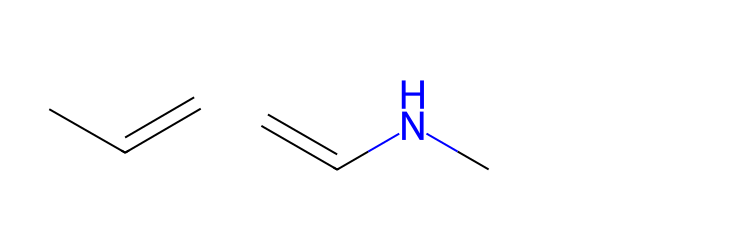

In [13]:
molecule1 = Chem.MolFromSmiles('CC=C')
molecule2 = Chem.MolFromSmiles('CNC=C')
Draw.MolsToGridImage((molecule1,molecule2), subImgSize=(250,250))

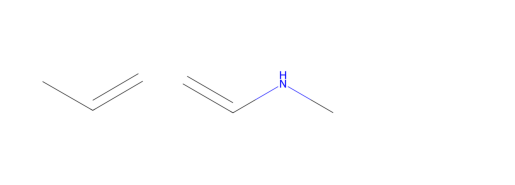

True

In [14]:
draw_and_save (smi = 'CC=C', GTsmile = 'CNC=C', fname='out.png', add_Hs=True)

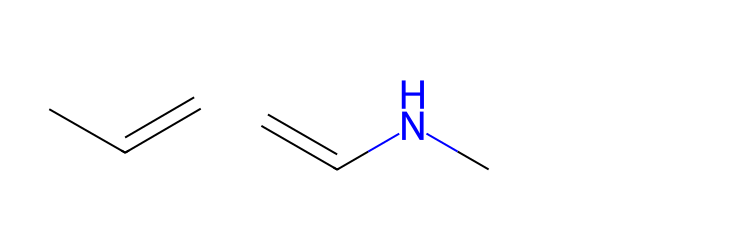

In [15]:
Draw.MolsToGridImage((molecule1,molecule2), subImgSize=(250,250))

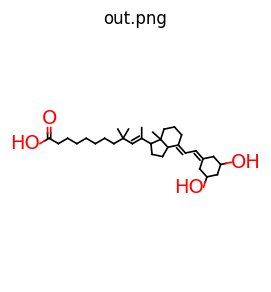

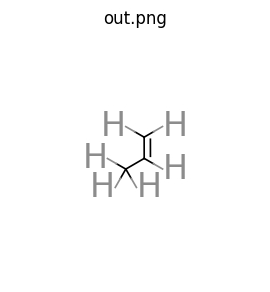

True

In [16]:
draw_and_save (smi = 'CC(=CC(C)(C)CCCCCCCC(=O)O)C1CCC2C(=CC=C3CC(O)CC(O)C3)CCCC21C', fname='out.png')
draw_and_save (smi = 'CC=C', fname='out.png', add_Hs=True)

### Define and normalize predicted properties y-data

We first normalize the y_data, molecular properties, to be in a range from -1...1

In [17]:
y_data=df.iloc [:, 1: ] .to_numpy()
y_data.shape

(133885, 12)

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) 
y_data = scaler.fit_transform(y_data, )  #array-like of shape (n_samples, n_features)
y_data.shape

(133885, 12)

In [19]:
#context_embedding_max_length defines the length of the predicted variables
context_embedding_max_length=y_data.shape[1]
context_embedding_max_length

12

In [20]:
scaler

MinMaxScaler(feature_range=(-1, 1))

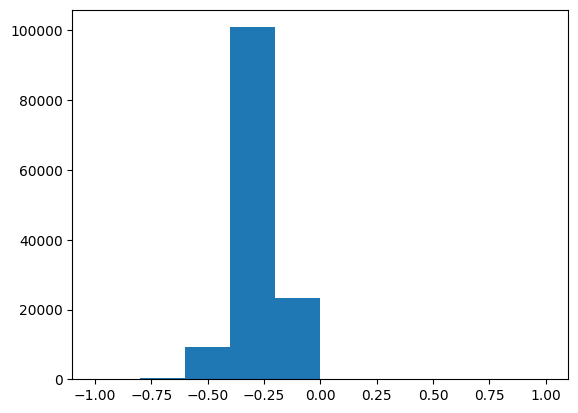

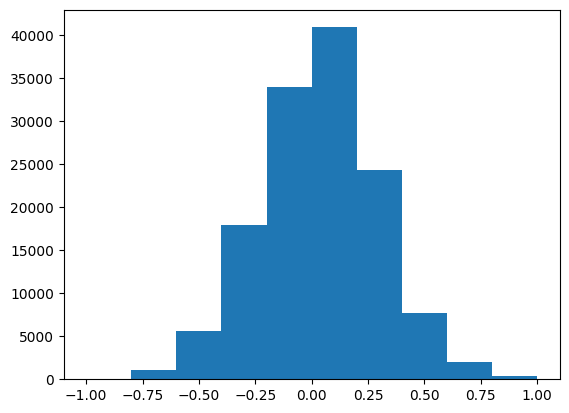

In [21]:
#show histograms of y_data for two examples
plt.hist (y_data[:,1])
plt.show()
plt.hist (y_data[:,6])
plt.show()

In [22]:
make_pairplot = False
if make_pairplot:
    sns_plot=sns.pairplot (df.iloc [:, 1: ])
    sns_plot.savefig("pairplot.svg")

### Define and normalize input properties X_data (SMILES strings)

In [23]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [24]:
X_data= df['smiles']

In [25]:
max_length_generative=32

len (X_data[:6])

res = max(X_data[:,], key = len)
max_length_data=len (res)
max_length= max (max_length_data, max_length_generative)

# printing result
print("Maximum length string is : " , res, "length=",max_length_data, "chosen length=", max_length)

Maximum length string is :  c1(=O)[nH]c(=O)[nH]c(=O)[nH]1 length= 29 chosen length= 32


In [26]:
max_length

32

In [27]:
X_data[:6]

0      C
1      N
2      O
3    C#C
4    C#N
5    C=O
Name: smiles, dtype: object

In [28]:
filters=''# '!"$%&()*+,-./:;<=>?[\\]^_`{|}\t\n'

tokenizer_X = Tokenizer(char_level=True, filters=filters, lower=False)
tokenizer_X.fit_on_texts(X_data)
        
X_data_tokenized = tokenizer_X.texts_to_sequences(X_data)

X_data_tokenized= sequence.pad_sequences(X_data_tokenized,  maxlen=max_length, padding='post', truncating='post') 

In [29]:
print ("#################################")
print ("DICTIONARY y_data")
dictt=tokenizer_X.get_config()
print (dictt)
print ("Length dictionary: ", len (dictt) )
num_words = len(tokenizer_X.word_index) + 1
num_words

#################################
DICTIONARY y_data
{'num_words': None, 'filters': '', 'lower': False, 'split': ' ', 'char_level': True, 'oov_token': None, 'document_count': 133885, 'word_counts': '{"C": 787482, "N": 109306, "O": 181161, "#": 37027, "=": 106335, "(": 126532, ")": 126532, "1": 270020, "c": 59074, "[": 9918, "n": 30458, "H": 8247, "]": 9918, "o": 6836, "3": 34756, "+": 1705, "-": 1808, "2": 121675, "F": 3314, "4": 5186, "5": 242}', 'word_docs': '{"C": 131656, "N": 74300, "O": 111215, "#": 32432, "=": 76005, ")": 92249, "(": 92249, "1": 119887, "]": 7941, "H": 7941, "n": 16002, "[": 7941, "c": 17698, "o": 6546, "3": 17627, "+": 1705, "-": 1808, "2": 60295, "F": 2163, "4": 2593, "5": 121}', 'index_docs': '{"1": 131656, "7": 74300, "3": 111215, "10": 32432, "8": 76005, "5": 92249, "4": 92249, "2": 119887, "14": 7941, "15": 7941, "12": 16002, "13": 7941, "9": 17698, "16": 6546, "11": 17627, "20": 1705, "19": 1808, "6": 60295, "18": 2163, "17": 2593, "21": 121}', 'index_word'

22

In [30]:
X_data_tokenized_reversed=reverse_tokenize (tokenizer_X, X_data_tokenized)

In [31]:
X_data [:6], X_data_tokenized[:6], X_data_tokenized_reversed[:6]

(0      C
 1      N
 2      O
 3    C#C
 4    C#N
 5    C=O
 Name: smiles, dtype: object,
 array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 10,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 10,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
       dtype=int32),
 ['C',

#### Normalize SMILES tokens and prepare one-hot encoding

In [32]:
#get max token number in training set
X_norm_factor=X_data_tokenized.max()
X_norm_factor

21

In [33]:
X_data_tokenized_norm=X_data_tokenized/X_norm_factor
print (X_norm_factor,  X_data_tokenized_norm.min(), X_data_tokenized_norm.max(),)

21 0.0 1.0


In [34]:
X_data_tokenized.shape

(133885, 32)

In [35]:
#make X_data_tokenized into tensor (not used in this code, but for transformer)
X_data_tokenized=torch.Tensor (X_data_tokenized).long () 
X_data_tokenized[0,:].shape

torch.Size([32])

In [36]:
X_data_tokenized_onehot=F.one_hot ( X_data_tokenized  ) 
X_data_tokenized_onehot[X_data_tokenized_onehot==0] = -1
X_data_tokenized_onehot=X_data_tokenized_onehot.float()

In [37]:
X_data_tokenized_onehot.shape

torch.Size([133885, 32, 22])

In [38]:
X_data_tokenized_onehot_reversed=torch.argmax(X_data_tokenized_onehot, dim=2)
X_data_tokenized_onehot_reversed.shape

torch.Size([133885, 32])

In [39]:
(X_data_tokenized_onehot_reversed-X_data_tokenized).nonzero() #the results should all be zero

tensor([], size=(0, 2), dtype=torch.int64)

In [40]:
batch_size=1024
train_loader,train_loader_noshuffle, test_loader= get_data_loaders (X_data_tokenized_onehot,  y_data ,  split=0.1, 
                                                                    batch_size_=batch_size)

print (f"Number of batches in training: {len (train_loader)}")

Shapes= torch.Size([133885, 32, 22]), (133885, 12)
Shapes of training/test for X and y:
torch.Size([120496, 32, 22])
torch.Size([120496, 12])
torch.Size([13389, 32, 22])
torch.Size([13389, 12])
Number of batches in training: 118


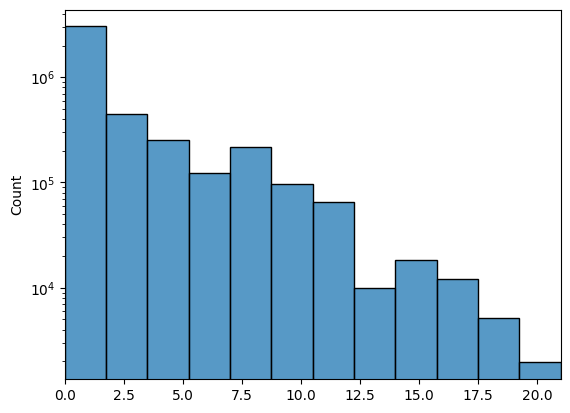

In [41]:
fig_handle =sns.histplot(np.array(X_data_tokenized).flatten(), bins=12,   log_scale=(False, True) )
fig = fig_handle.get_figure()
fig_handle.set_xlim(0, X_norm_factor)
#fig_handle.set_ylim(0, 100000)
#plt.xticks(range (1,21))
plt.show()

### Define forward diffusion model (used to validate predictions)

In [42]:
from  MoleculeDiffusion import QMDiffusionForward 
from  MoleculeDiffusion import predict_properties_from_SMILES, count_parameters

In [43]:
pred_dim=1
max_length_forward=64
context_embedding_max_length=y_data.shape[1]

model_forward =QMDiffusionForward( 
                 max_length=max_length_forward,#context_embedding_max_length,#length of predicted data
                 pred_dim=pred_dim,
                 channels=64,
                 unet_type='cfg', #'base', #'cfg',
                 context_embedding_max_length=max_length_forward,  #length of conditioning 
                 pos_emb_fourier=True,
                 pos_emb_fourier_add=False,
                 text_embed_dim = 64,
                 embed_dim_position=64,
                 )  .to(device)  

count_parameters (model_forward)
 
fname=f'./diffusion_forward/statedict_save-model-epoch_78.pt' #lowest loss mode
model_forward.load_state_dict(torch.load(fname))
print ("Loaded model.")

[<class 'MoleculeDiffusion.diffusion.VDiffusion'>, <class 'MoleculeDiffusion.diffusion.KDiffusion'>, <class 'MoleculeDiffusion.diffusion.VKDiffusion'>, <class 'MoleculeDiffusion.diffusion.KDiffusion_mod'>]
----------------------------------------------------------------------------------------------------
Total parameters:  18322684  trainable parameters:  18322684
----------------------------------------------------------------------------------------------------
Loaded model.


### Test inference of forward model

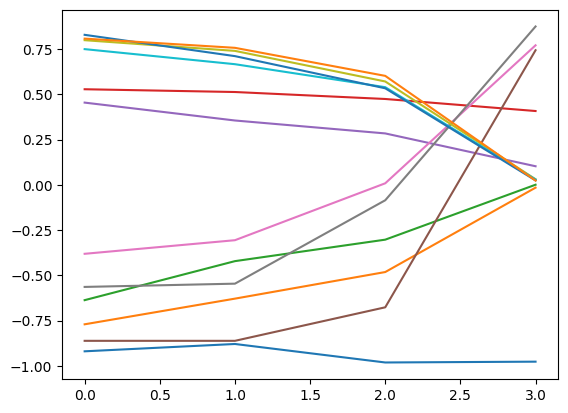

In [44]:
res, _=predict_properties_from_SMILES (model_forward,device, SMILES=['C',
                                                                     'CCC',
                                                                     'CCCCCC',
                                                                     'CCCCCCCCC'], 
                X_norm_factor=X_norm_factor,
                scaler=scaler,
                tokenizer_X=tokenizer_X,
                 
                cond_scales=[1.], #list of cond scales - each sampled...
                
                timesteps=100,
                flag=0, 
                clamp=False,
                 
                draw_molecules=False,
                draw_all=False,
                mols_per_row=8,max_length = 64,
                                       
                context_embedding_max_length=12, 
               )

plt.plot (res[:,:])
plt.show()

### Set up generative diffusion model

In [45]:
from  MoleculeDiffusion import  QMDiffusion, sample_loop_generative, train_loop_generative

prefix='./QM_generative_diffusion_inverse/'
if not os.path.exists(prefix):
        os.mkdir (prefix)

In [46]:
max_length, X_data_tokenized_onehot.shape, context_embedding_max_length, len (train_loader)

(32, torch.Size([133885, 32, 22]), 12, 118)

In [49]:
train_generative = False #False

In [50]:
max_length_generative = 32

pred_dim=X_data_tokenized_onehot.shape[2]
print (pred_dim)
 
context_embedding_max_length=y_data.shape[1]
model =QMDiffusion( 
                 max_length=max_length_generative,#length of predicted data
                 pred_dim=pred_dim,
                 channels=128,
                 unet_type='cfg', #'base', #'cfg',
                 context_embedding_max_length=context_embedding_max_length,#length of conditioning 
                 pos_emb_fourier=True,
                 pos_emb_fourier_add=False,
                 text_embed_dim = 64,
                 embed_dim_position=64,
            )  .to(device)  

count_parameters (model)

if train_generative:
 
    optimizer = optim.Adam(model.parameters() , lr=0.0002 )
    
else:
    
    fname=f'./QM_generative_diffusion_inverse/statedict_save-model-epoch_4851.pt' #lowest loss mode
    model.load_state_dict(torch.load(fname))
    print ("Model loaded.")

22
Using unet type:  cfg
[<class 'MoleculeDiffusion.diffusion.VDiffusion'>, <class 'MoleculeDiffusion.diffusion.KDiffusion'>, <class 'MoleculeDiffusion.diffusion.VKDiffusion'>, <class 'MoleculeDiffusion.diffusion.KDiffusion_mod'>]
----------------------------------------------------------------------------------------------------
Total parameters:  90965554  trainable parameters:  90965554
----------------------------------------------------------------------------------------------------


In [51]:
X_norm_factor

21

In [52]:
device

device(type='cuda')

In [ ]:
if train_generative:
    loss_list=[]
    loss_list=train_loop_generative (model,
                train_loader,test_loader,model_forward=model_forward,
                optimizer=optimizer,
                print_every=1000,
                epochs= 3000000, #stop early 
                start_ep=0,
                start_step=0,
                print_loss=1*len (train_loader),
                cond_scales=[1.],
                timesteps=100,
                clamp=False,
                save_model=True,
                show_jointplot=True,
                num_samples=2,
                ALL_SMILES=ALL_SMILES,
                scaler=scaler,
                X_norm_factor=X_norm_factor, #need for forward 
                prefix=prefix,
                device=device,
                loss_list=loss_list,
                tokenizer_X=tokenizer_X,
               )

In [ ]:
sample_loop_generative (model,device,
                test_loader, 
                tokenizer_X=tokenizer_X,
                cond_scales=[1,], #list of cond scales - each sampled...
                num_samples=4, #how many samples produced every time tested.....
                timesteps=100,show_jointplot=True ,
                draw_molecules=True, 
                ALL_SMILES=ALL_SMILES,
                model_forward=model_forward,
                scaler=scaler,
                X_norm_factor=X_norm_factor, #need for forward 
                prefix=prefix,
                )